In this notebook, we compare the distribution of the GLM MFX statistic obtained by Monte Carlo simulation with its theoretical distribution.

In [1]:
import nibabel as nib
import os
import numpy as np
import scipy
import pandas as pd
import scipy.stats
from distribution_plots import *

## Description of the Monte Carlo simulation setup
Study level contrast estimates (denoted $\beta_i$'s) and contrast variance estimates (denoted $\sigma_i$'s) were simulated according to:
$$
\beta_i \sim \mathcal{N}(0, \sigma_i^2+\tau^2)
$$

$$
s^2_i \sim \chi^2_{n-1}*\frac{\sigma_i^2}{n-1}
$$

with 
$$
\sigma_i^2 = \frac{\sigma^2*a_i}{n}
$$

where:
 - $\tau^2=1$ is the between-study variance, 
 - $\sigma_i^2$ is the variance of contrast estimate for study i (i.e. the within-study variance divided by $n$) and 
 - $n=20$ is the number of subjects per studies.
 
6 different simulation schemes were computed:
 - 'diff': $\sigma^2_i \in \{0.25, 0.5, 1, 2, 4\}$
 - '05': $\sigma^2_i=\frac{5}{n}=0.25 \; \forall i$
 - '10': $\sigma^2_i=\frac{10}{n}=0.50 \; \forall i$
 - '20': $\sigma^2_i=\frac{20}{n}=1 \; \forall i$
 - '40': $\sigma^2_i=\frac{40}{n}=2 \; \forall i$
 - '80': $\sigma^2_i=\frac{80}{n}=4 \; \forall i$
 
A total of $38*30*30*30$ random sampling were computed for each simulation setting.

## Load simulation results

In [2]:
# Simulation parameters
nrep = 38; # 38 repeats are available
nsimuperrep = 30*30*30
nreal = nrep*nsimuperrep # Total number of realisations

tau2 = 1 # Between-study variance
nsubjects = 20 # Number of subjects per study

varcope_sigma2 = [0.25, 0.5, 1, 2, 4]
sigma2 = dict(('{num:02d}'.format(num=int(t*nsubjects)), 
               '$\\tau^2 = 1, \sigma^2_i = ' + str(t) + '$')  
              for t in varcope_sigma2) # Possible within-study variances (constant across studies)
sigma2['diff'] = '$\\tau^2 = 1, \sigma^2_i \in  \{0.25, 0.5, 1, 2, 4\}$'
sigma2['diff_1.5'] = '$\\tau^2 = 1, \sigma^2_i \in  \{0.25-4\}$'
sigma2['diff_1.5'] = '$\\tau^2 = 1, \sigma^2_i \in  \{1-5\}'
sigma2['diff_3'] = '$\\tau^2 = 1, \sigma^2_i \in  \{1-32\}'

kstudies = 25 # Number of studies in the meta-analysis (one-sample)
dof = kstudies - 1 # Degrees of freedom

In [3]:
# Load the data
base_dir = '/Volumes/camille/IBMA_simu/'

wth_n20 = dict()

hat_taus = {k: [] for k in sigma2.keys()} # mean_random_effects_var1.nii.gz concatenated across (independent) runs & voxels
tstats = {k: [] for k in sigma2.keys()} # tstat1.nii.gz concatenated across (independent) runs & voxels
zstats = {k: [] for k in sigma2.keys()} # zstat1.nii.gz concatenated across (independent) runs & voxels
meta_varcopes = {k: [] for k in sigma2.keys()} # varcope1.nii.gz concatenated across (independent) runs & voxels
meta_copes = {k: [] for k in sigma2.keys()} # cope1.nii.gz concatenated across (independent) runs & voxels

for wth in sigma2.keys():
    for r in range(1, nrep+1):
        wth_n20[wth, r] = os.path.join(
            base_dir, 
            'test1_k025_n20_btw1_wth' + wth + '_nominal', 
            '{num:04d}'.format(num=r), # Repeat
            'megaMFX/')

for [wth, r], folder in wth_n20.items():
    data_array = nib.load(os.path.join(wth_n20[wth,r], 'stats', 'mean_random_effects_var1.nii.gz')).get_data().flatten()
    hat_taus[wth] = np.append(hat_taus[wth], data_array)
    z_data_array = nib.load(os.path.join(wth_n20[wth,r], 'stats', 'zstat1.nii.gz')).get_data().flatten()
    zstats[wth] = np.append(zstats[wth], z_data_array)
    t_data_array = nib.load(os.path.join(wth_n20[wth,r], 'stats', 'tstat1.nii.gz')).get_data().flatten()
    tstats[wth] = np.append(tstats[wth], t_data_array)
    varcope_array = nib.load(os.path.join(wth_n20[wth,r], 'stats', 'varcope1.nii.gz')).get_data().flatten()
    meta_varcopes[wth] = np.append(meta_varcopes[wth], varcope_array)
    cope_array = nib.load(os.path.join(wth_n20[wth,r], 'stats', 'cope1.nii.gz')).get_data().flatten()
    meta_copes[wth] = np.append(meta_copes[wth], cope_array)

In [4]:
wth_todisp = ['diff', '05', '80'] # Settings to be displayed

## Problem statement

Issue: P-values obtained under the null hypothesis on simulated data presenting varying within-study variance are invalid (first plot below). 

As expected, with constant within-study variance the P-values are either valid (if $\sigma^2_i << \tau^2$, second plot below) or conservative (if $\sigma^2_i >> \tau^2$, third plot below).


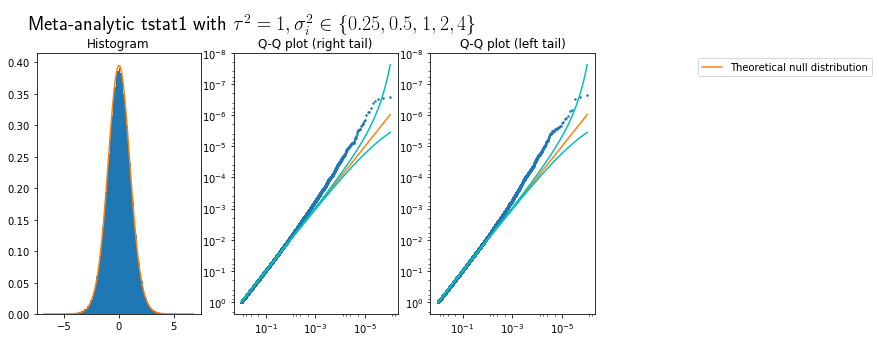

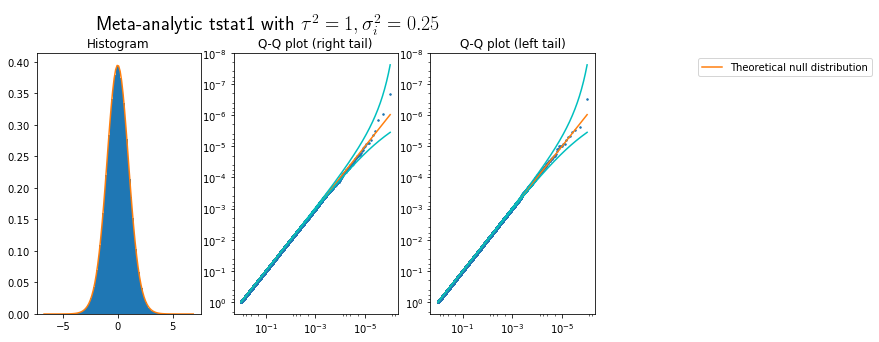

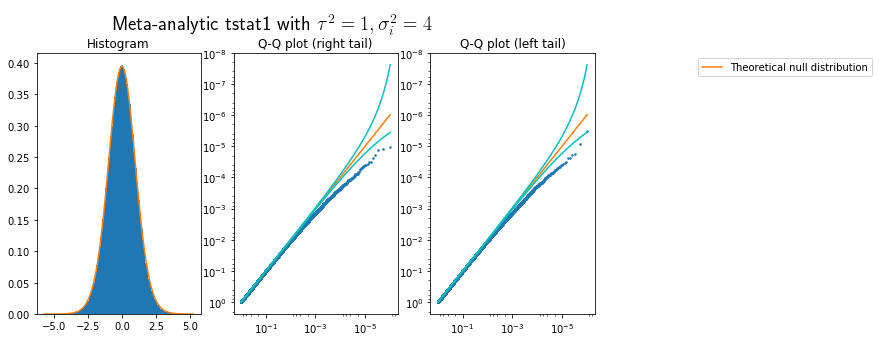

In [5]:
for wth in wth_todisp:
    t_distribution_plot(tstats[wth], 'Meta-analytic tstat1 with ' + sigma2[wth], dof)

## Distribution of the numerator of the T-statistic

Here we look at the distribution of the numerator of the meta-analysic t-statistic which corresponds to the `cope1.nii.gz` file generated at the meta-analytic level.

The theoretical distribution of `cope1.nii.gz` under the null is computed below.

### Theoretical distribution of the meta-analysis cope under H0

With MFX GLM under the null the meta-analysis cope (denoted $\gamma$) follows:
$$
\gamma \sim \mathcal{N}(0, \frac{1}{\sum \kappa_i})
$$
with $\kappa_i = 1/(\tau^2 + \sigma_i^2)$

For the different simulation settings:
 - diff': with $\sigma^2_i \in  \{0.25, 0.5, 1, 2, 4\}$ $\gamma \sim \mathcal{N}(0, \frac{1}{1/1.25 + 1/1.5 + 1/2 + 1/3 + 1/5+1/1.25 + 1/1.5 + 1/2 + 1/3 + 1/5+1/1.25 + 1/1.5 + 1/2 + 1/3 + 1/5+1/1.25 + 1/1.5 + 1/2 + 1/3 + 1/5+1/1.25 + 1/1.5 + 1/2 + 1/3 + 1/5})$
 - 05: with $\sigma^2_i=0.25$, we have $\gamma \sim \mathcal{N}(0, \frac{1.25}{k})$
 - 10: with $\sigma^2_i=0.5$ $\gamma \sim \mathcal{N}(0, \frac{1.5}{k})$
 - 20: with $\sigma^2_i=1$ $\gamma \sim \mathcal{N}(0, \frac{2}{k})$
 - 40: with $\sigma^2_i=2$ $\gamma \sim \mathcal{N}(0, \frac{3}{k})$
 - 80: with $\sigma^2_i=4$ $\gamma \sim \mathcal{N}(0, \frac{4}{k})$
 
where $k=25$ is the number of studies included in the meta-analysis.

In [6]:
tau2 = 1
kstudies = 25
cope_th_var = dict()

def get_mfx_th_variance(tau2, sigma2_i):
    sigma2_i_ratios = [1/(tau2 + x) for x in sigma2_i]
    th_var_diff = 1/sum(sigma2_i_ratios)
    return(th_var_diff)

# From os.path.join(wth_n20['diff'], os.pardir, 'simu.mat') we see:
wth_sigma_a = [1, 2, 4, 8, 16, 1, 2, 4, 8, 16, 1, 2, 4, 8, 16, 1, 2, 4, 8, 16, 1, 2, 4, 8, 16]
sigma2_i = [x * 0.25 for x in wth_sigma_a]
cope_th_var['diff'] = get_mfx_th_variance(tau2, sigma2_i)

# Test calculation with constant within-study variance (sanity check)
sigma2_i = [x*0.25 for x in np.ones(kstudies)]
cope_th_var['05'] = get_mfx_th_variance(tau2, sigma2_i)

if np.isclose(get_mfx_th_variance(tau2, sigma2_i),(tau2+0.25)/kstudies):
    print('Sanity check succeded')
else:
    print('Sanity check failed!')
    print('th_var_cope_05=' + str(get_mfx_th_variance(tau2, sigma2_i)))
    print('th_var_cope_05=' + str((tau2+0.25)/kstudies))
    
cope_th_var['10'] = get_mfx_th_variance(tau2, [x*0.5 for x in np.ones(kstudies)])
cope_th_var['20'] = get_mfx_th_variance(tau2, [x*1 for x in np.ones(kstudies)])
cope_th_var['40'] = get_mfx_th_variance(tau2, [x*2 for x in np.ones(kstudies)])
cope_th_var['80'] = get_mfx_th_variance(tau2, [x*4 for x in np.ones(kstudies)])

Sanity check succeded


### Observed distribution of the meta-analytic cope
We plot the observed distribution of the `cope1.nii.gz` against the theoretical distribution under the null are provided below.

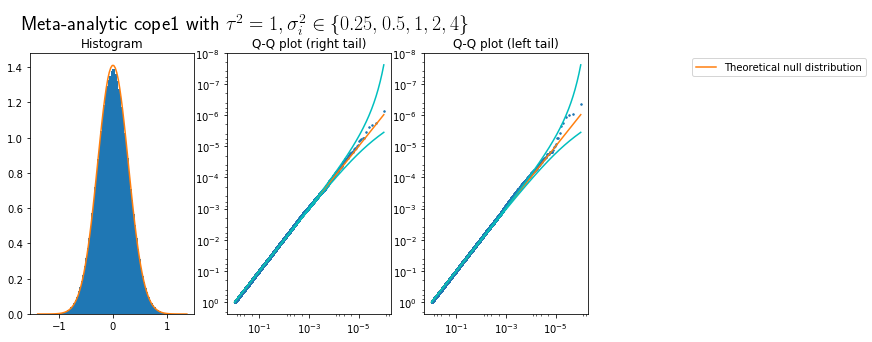

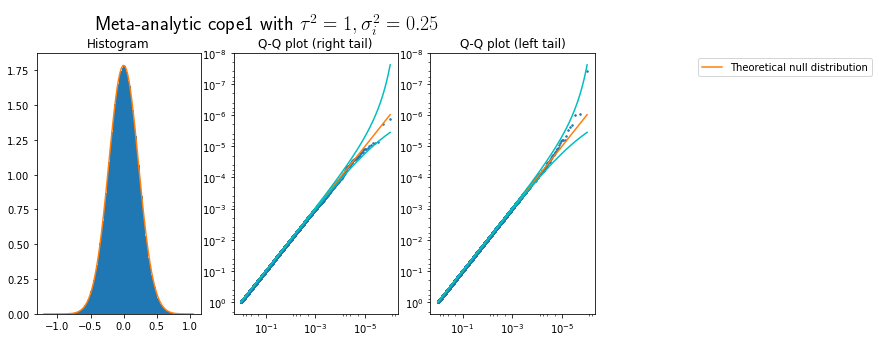

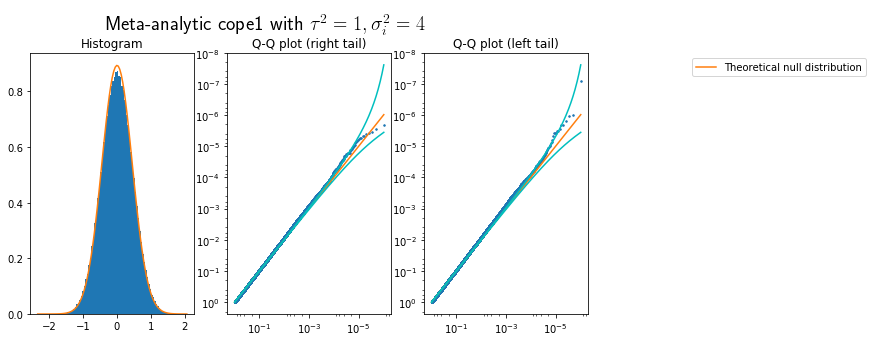

In [7]:
for wth in wth_todisp:
    z_distribution_plot(
        meta_copes[wth], # cope to display
        'Meta-analytic cope1 with ' + sigma2[wth], # Title
        0, np.sqrt(cope_th_var[wth]) # Parameters of the theoretical Normal distribution
    )

## Distribution of the denominator of the T-statistic

Here we look at the distribution of the denomerator of the meta-analysis t-statistic which corresponds to the `varcope1.nii.gz` file generated at the meta-analytic level.

The theoretical distribution of `varcope1.nii.gz` under the null is computed below. 

### Theoretical distribution of the meta-analysis varcope under H0

With MFX GLM under the null the meta-analysis varcope (denoted $Var(\gamma)$) is assumed to follow:
$$
Var(\gamma) \sim \chi^2_{k-1} \frac{1}{(k-1) \sum \kappa_i}
$$
with $\kappa_i = 1/(\tau^2 + \sigma_i^2)$

For the different simulation settings:
 - diff: with $\sigma^2_i \in  \{0.25, 0.5, 1, 2, 4\}$ $Var(\gamma) \sim \chi^2_{k-1} \frac{1}{1/1.25 + 1/1.5 + 1/2 + 1/3 + 1/5+1/1.25 + 1/1.5 + 1/2 + 1/3 + 1/5+1/1.25 + 1/1.5 + 1/2 + 1/3 + 1/5+1/1.25 + 1/1.5 + 1/2 + 1/3 + 1/5+1/1.25 + 1/1.5 + 1/2 + 1/3 + 1/5} \frac{1}{k-1} $
 - 05: with $\sigma^2_i=0.25$, we have $Var(\gamma) \sim \chi^2_{k-1} \frac{1.25}{k} \frac{1}{k-1} $
 - 10: with $\sigma^2_i=0.5$ $Var(\gamma) \sim \chi^2_{k-1} \frac{1.5}{k} \frac{1}{k-1} $
 - 20: with $\sigma^2_i=1$ $Var(\gamma) \sim \chi^2_{k-1} \frac{2}{k} \frac{1}{k-1} $
 - 40: with $\sigma^2_i=2$ $Var(\gamma) \sim \chi^2_{k-1} \frac{3}{k} \frac{1}{k-1} $
 - 80: with $\sigma^2_i=4$ $Var(\gamma) \sim \chi^2_{k-1} \frac{4}{k} \frac{1}{k-1} $
 
where $k=25$ is the number of studies included in the meta-analysis.

### Observed distribution of the meta-analytic varcope
We plot the observed distribution of the `varcope1.nii.gz` against the theoretical distribution under the null are provided below.

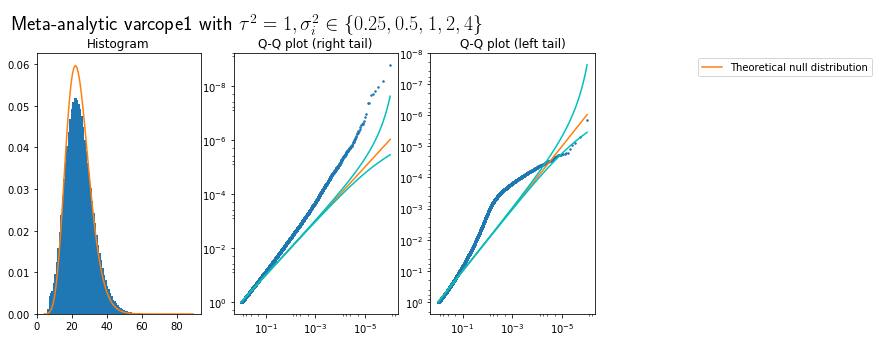

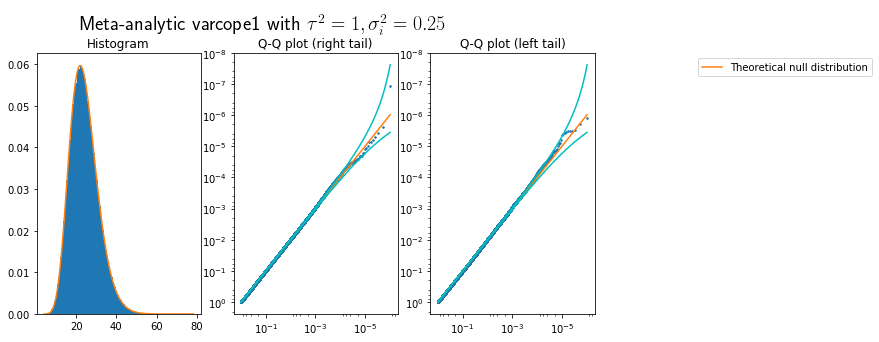

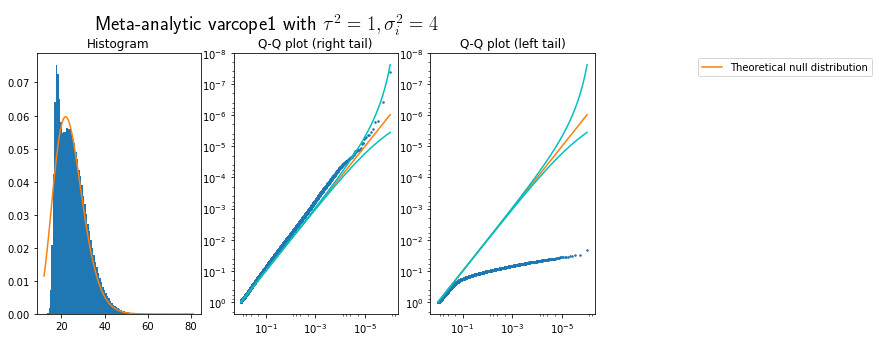

In [8]:
for wth in wth_todisp:
    chi2_distribution_plot(
        meta_varcopes[wth]*dof/(cope_th_var[wth]), # varcope to display scaled by sigma2/dof
        'Meta-analytic varcope1 with ' + sigma2[wth], 
        dof # Parameters of the theoretical Chi2 distribution
    )

### Look for bias in the meta-analysis varcopes

In [11]:
for wth in wth_todisp:
    _mu = np.mean(meta_varcopes[wth])
    print('Mean meta-analytic varcope1 (over ' + str(nreal) + ' realisations) for ' + wth + ' = ' + 
          "{0:.4f}".format(_mu) + ' / True varcope1=' + "{0:.4f}".format(cope_th_var[wth]))

Mean meta-analytic varcope1 (over 1026000 realisations) for diff = 0.0810 / True varcope1=0.0800
Mean meta-analytic varcope1 (over 1026000 realisations) for 05 = 0.0501 / True varcope1=0.0500
Mean meta-analytic varcope1 (over 1026000 realisations) for 80 = 0.2109 / True varcope1=0.2000


### Estimated degrees of freedom for the meta-analysis varcopes using Satterwaite approximation   

In [12]:
for wth in wth_todisp:
    _mu = np.mean(meta_varcopes[wth])
    _sigma2 = np.var(meta_varcopes[wth])
    nu = 2*_mu*_mu/(_sigma2)
    c = (_sigma2)/(2*_mu)
    print('Estimated dof of meta-analytic varcope1 (over ' + str(nreal) + ' realisations) for \'' + wth + '\': ' + 
          ' nu=' + "{0:.1f}".format(nu) + '/ True nu=' + str(dof) )

Estimated dof of meta-analytic varcope1 (over 1026000 realisations) for 'diff':  nu=18.5/ True nu=24
Estimated dof of meta-analytic varcope1 (over 1026000 realisations) for '05':  nu=23.9/ True nu=24
Estimated dof of meta-analytic varcope1 (over 1026000 realisations) for '80':  nu=28.4/ True nu=24
